<h1 align="center">Final Project: Using Machine Learning to Resolve Ambiguity in Emotion</h1>

<br />

<h4 align="center">PHYSICS 3G03 – Introduction to Neural Networks and Machine Learning </h4>
<h4 align="center">C.J. Moreno </h4>
<h4 align="center">400207537 </h4>
<h4 align="center">April 30, 2022 </h4>
<br />

## Introduction

**Humans are largely communal animals**, to such a degree that social behaviour plays an essential role in daily life. An important cue that influences social behaviour is emotion – a state of consciousness such as happiness, fear, and disgust. The ability to understand one's own feelings and accurately interpret other's emotions is important when choosing how to interact with someone. For example, if a person is undeniably demonstrating sadness, laughing may not be the most appropriate response. Unfortunately, **10 % of the general population live with alexithymia**, the inability to identify and describe emotions. Alexithymia commonly occurs alongside anxiety disorders, depressive disorders, obsessive-compulsive disorder, and autism spectrum disorder. Consequently, many people with these disorders struggle in social situations and require assistance in determining and describing emotions. 

>_"Because emotions have this communicative signal value, they help solve social problems by evoking responses from others, by signaling the nature of interpersonal relationships, and by providing incentives for desired social behavior (Keltner, 2003)"_

The proposed final project investigates machine learning methods to resolve emotion-related ambiguity experienced in mental health disorders. The FER - 2013 training and testing images will be preprocessed with **ESRGAN** which is then fed into the **MediaPipe Face Mesh** algorithm to determine facial landmarks. Features will be extracted to train the **k-nearest neighbor** and **multilayer perceptron** models of classification. The images will be classified between 7 classes of emotion: _angry, disgusted, fearful, happy, neutral, sad, and surprised_

## General Image Classification Process:

### A) Image Preprocessing
Most large-scale datasets for image classification contain images that are low-resolution in order to minimize the amount of storage required. However, this imposes an obstacle when implementing algorithms for feature detection as limited pixel information hinders our ability to distinguish between subtle edges in order to extract nuanced characteristics of an image. Hence, we must preprocess the images to improve the data features by suppressing distortions and enhancing the resolution. 

### B) Facial Landmark Detection
The preprocessed images are then put through a machine learning algorithm in order to detect and localize the object of interest, in this case are faces. The x,y,z coordinates of major facial landmarks are recorded as vertices to create a facemesh. Crucial components such as the eyes, nose, and lips are further outlined in order to obtain data required for classification. 

### C) Feature Extraction
Key landmark features are drawn from the facemesh in order to minimize the amount of data that is being processed in later stages of classification. The exclusion of less important datapoints help to minmize both computing time and computing power requirements. After obtaining the key landmarks, a spatial feature of the landmarks are obtain for the classification process.

### D) Training & Object Classification 
The spatial features are recorded for each image and inputed into a machine learning classification algorithm along with expected label values for training. Once sufficiently trained with training images & labels for all the classes, the algorithm can then be tested using test images. The accuracy of classification is then recorded to fine-tune hyperparameters. 

### Importing Libraries 

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
import mediapipe as mp
import cv2
from mediapipe.framework.formats import landmark_pb2

## IMAGE PREPROCESSING – Enhanced Super Resolution Generative Adversarial Network (ESRGAN) 

ESRGAN is a technique that utilizes deep convolutional neural networks to derive high-resolution images from low-resolution images. The enhanced version builds from SRGAN to improve network architecture, adversarial loss, and perceptual loss. ESRGAN achieves enhanced visual quality while producing realistic and natural textures. 

**The Algorithm Architecture:** SRResNet-based format in which the algorithm contains a (1) generator network and a (2) discriminator network. The generator network contains a system of Residual-in-Residual Dense Block (RRDB) without batch normalization. Each RRDB has conventional sets of Conv-ReLU blocks as the basic network building unit in order to reconstruct super resolution images. The discriminator network is a conventional convolution neural network that predicts relative realness of a super-resolved image by classifying whether an image is real or false.  

In [2]:
# To use ESRGAN, the input image must be 4-dimensional, with color channels = 3
def preprocess_image(file,directory):
    
    os.chdir(directory) # change directory to access image
    hr_image = tf.image.decode_image(tf.io.read_file(file),channels=3)
    
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32) # convert to float32 image    
    
    return tf.expand_dims(hr_image, 0) # 3D --> 4D

In [3]:
# Directly input the ESRGAN model 
ESRGAN_MODEL_PATH = 'https://tfhub.dev/captain-pool/esrgan-tf2/1'
sr_model = hub.load(ESRGAN_MODEL_PATH)

2022-04-30 16:16:28.753386: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-30 16:16:28.753570: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


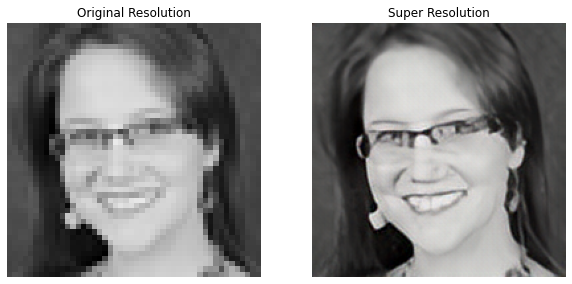

In [4]:
# Example from dataset using ESRGAN to preprocess
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 7.5))
ax1.imshow(tf.io.decode_image(tf.io.read_file("im0.png"),channels=3),cmap='gray')
ax1.title.set_text("Original Resolution")
ax1.set_axis_off()
ax2.imshow(tf.io.decode_image(tf.io.read_file("sr_image.png"),channels=3),cmap='gray')
ax2.title.set_text("Super Resolution")
ax2.set_axis_off()
plt.show()

#### Observation from the ESRGAN Output 
Compared to the original image (left), the ESRGAN output produced a realistic high-resolution version (right) that maintained accurate proportions between the facial features. Moreover, there does not appear to be any significant distortions in the number and location of the edges, which provide high fecundity for our results. 

## FACIAL LANDMARK DETECTION – MediaPipe Face Mesh Solution

MediaPipe Face Mesh is a machine learning algorithm that estimates 468 3D facial landmarks. It consists of three deep neural network models that work to detect the face in space and estimate 3D surface locations that create the structural components of the face. 

**The Algorithm Architecture:** (1) Face detection model is a neural network that follows the BlazeFace architecture which utilizes 5x5 convolution kernels in a bottleneck fashion to detect faces in images. (2) Face landmark model is an end-to-end neural network that uses the face locations and approximates 3D surfaces via regression. (3) Attention mesh model increases the accuracy of landmark prediction by focusing and enhancing semantically meaningful components of the input while diminishing the less important parts – often trained by gradient descent. 

In [4]:
# code for mesh visualization --> https://google.github.io/mediapipe/solutions/face_mesh.html
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

# For static images – MediaPipe finds 468 facial landmarks
IMAGE_FILES = ['sr_image.png']
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks: # Mesh --> head & lips outline --> eyes
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())  
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_contours_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_iris_connections_style())
    cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)

In [4]:
# Do not need the entire block of code for our emotion classification algorithm 
# This modified version will extract only the locations of the 468 facial + iris landmarks

def full_facial_landmarks(IMAGE_FILES):
    
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_face_mesh = mp.solutions.face_mesh    
    IMAGE_FILES = [IMAGE_FILES]
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
      for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if not results.multi_face_landmarks:
            continue

    if results.multi_face_landmarks != None:
        for face_landmarks in results.multi_face_landmarks:
            return face_landmarks

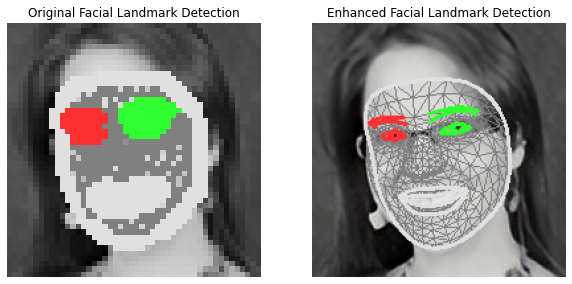

In [5]:
# Example using MediaPipe Face Mesh on data to detect facial landmarks – code obtained from MediaPipe documentation
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 7.5))
ax1.imshow(tf.io.decode_image(tf.io.read_file("not_refined.png"),channels=3),cmap='gray')
ax1.title.set_text("Original Facial Landmark Detection")
ax1.set_axis_off()
ax2.imshow(tf.io.decode_image(tf.io.read_file("facial_landmarks_image0.png"),channels=3),cmap='gray')
ax2.title.set_text("Enhanced Facial Landmark Detection")
ax2.set_axis_off()
plt.show()

#### Observations from the Face Mesh 
The above image demonstrates the importance of preprocessing images in order to execute accurate facial landmark detection. Running the MediaPipe Face Mesh algorithm on the original resolution image resulted in facial landmarks that cover large regions of the face and are completely overlapping with one another. On the other hand, the high-resoluton image produced a facial landmark map that is more robust. The 468 landmarks can be clearly visualized as they are localized in on a smaller region of the face. Moreover, crucial regions of the face such as the eyes, nose, and lips are much more defined in comparison to the original image. 

## KEY LANDMARK SELECTION, EMOTIONAL MESH GENERATION, AND MESH ANGULAR ENCODING 

Key landmark selection is based on the Facial Action Coding System (FACS), which are a set of facial muscle movements that are modified with changes in emotion. Attenuating the number of landmarks we focus on to those that describe the FACS will allow us to reduce the computational costs of our algorithm. Here, 27 facial landmarks were chosen to generate a refined facial landmark map, which was used to make an emotional mesh in which some of the vertices were connected. Ten feature angles were calculated based on the emotional mesh and will be used to classify between the different emotions.

In [5]:
# FACS indices of MediaPipe landmakrs provided by Siam et al. (2021)
# Create subset of landmarks containing action units for emotion detection

def key_landmarks(whole_landmarks):
    
    if whole_landmarks != None: 
        key_landmark = whole_landmarks.landmark

        landmark_subset = landmark_pb2.NormalizedLandmarkList(
          landmark = [
              key_landmark[61],
              key_landmark[292], 
              key_landmark[0],
              key_landmark[17],
              key_landmark[50],
              key_landmark[280], 
              key_landmark[48],
              key_landmark[4],
              key_landmark[289],
              key_landmark[206], 
              key_landmark[426],
              key_landmark[133],
              key_landmark[130],
              key_landmark[159], 
              key_landmark[145],
              key_landmark[362],
              key_landmark[359],
              key_landmark[386], 
              key_landmark[374],
              key_landmark[122],
              key_landmark[351],
              key_landmark[46], 
              key_landmark[105],
              key_landmark[107],
              key_landmark[276],
              key_landmark[334], 
              key_landmark[336]
          ]
        )

        return landmark_subset

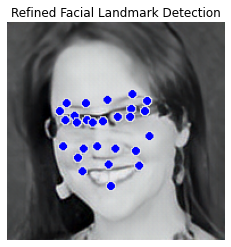

In [9]:
# Example of Refined Facial Landmark Detection by indexing select landmarks based on FACS
plt.imshow(tf.io.decode_image(tf.io.read_file('refined_landmarks_image0.png')))
plt.title("Refined Facial Landmark Detection")
plt.axis('off')
plt.show()

#### Observations from the Subset Facial Landmarks
The major landmarks that encode the action units, based on the FACS, appear to be located near important regions of the face such as the eyes, eyebrows, nose, and lips. There are 27 of these landmarks which are depicted by blue dots in the above image. 

In [42]:
# Modified Mesh Generation 

# Connect subset of vertices to generate emotional mesh connections
refined_connections = frozenset(((0,2),(0,3),(1,2),(1,3),(7,6),(7,8),(6,4),(8,5),(6,9),(9,0),(4,0), 
                         (8,10),(10,1), (7,19),(7,20),(7,0),(7,1),(19,23),(19,14),(23,22),
                         (22,21),(21,12),(12,13),(12,14),(11,13),(11,14),(14,4),(20,26),
                         (26,25),(25,24),(24,16),(16,17),(16,18),(15,17),(15,18),(18,20),
                         (18,5),(5,1)))

# Plot subset landmarks on image
mp_drawing.draw_landmarks(
    image=annotated_image,
    connections = refined_connections,
    landmark_list=landmark_subset,
    landmark_drawing_spec=None,
    connection_drawing_spec=mp_drawing.DrawingSpec(thickness=1, circle_radius=1, color=(255, 0, 0)))
# cv2.imwrite('/tmp/annotated_image_refined_mesh' + str(idx) + '.png', annotated_image)

NameError: name 'mp_drawing' is not defined

2022-04-29 20:23:11.332235: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-29 20:23:11.332781: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


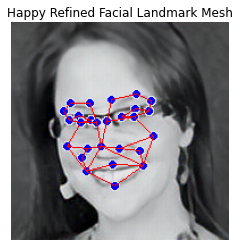

In [2]:
# Example of Emotional Facial Mesh by creating refined connections of landmark vertices via frozenset 
plt.imshow(tf.io.decode_image(tf.io.read_file('refined_mesh_image0.png')))
plt.title("Happy Refined Facial Landmark Mesh")
plt.axis('off')
plt.show()

#### Observations from the Emotional Mesh 
Connecting the vertices allows the visualization of regions corresponding to facial muscles responsible for the change in appearance during different emotional states. These geometric regions change considerably between the different types of emotional images.

**Equation for feature angles:**

$ \theta = \arctan(\frac{y_{3} - y_{2}}{x_{3} - x_{2}}) - \arctan(\frac{y_{1} - y_{2}}{x_{1} - x_{2}})  $, where (x,y) correspond to the coordinates of the facial landmarks as vertices.

In [6]:
# Create our 10 theta features described by Siam et al. (2021), which will be fed into classifier 
# If resultant angle is negative, add 360 degrees

def angular_encoding(subset):
    
    subset = subset.landmark
    
    theta_1 = np.degrees(np.arctan((subset[3].y - subset[0].y)/(subset[3].x - subset[0].x)) - np.arctan((subset[2].y - subset[0].y)/(subset[2].x - subset[0].x)))
    if theta_1 < 0:
        theta_1 += 360
    theta_2 = np.degrees(np.arctan((subset[1].y - subset[2].y)/(subset[1].x - subset[2].x)) - np.arctan((subset[0].y - subset[2].y)/(subset[0].x - subset[2].x)))
    if theta_2 < 0:
        theta_2 += 360
    theta_3 = np.degrees(np.arctan((subset[8].y - subset[7].y)/(subset[8].x - subset[7].x)) - np.arctan((subset[6].y - subset[7].y)/(subset[6].x - subset[7].x)))
    if theta_3 < 0:
        theta_3 += 360
    theta_4 = np.degrees(np.arctan((subset[10].y - subset[7].y)/(subset[10].x - subset[7].x)) - np.arctan((subset[9].y - subset[7].y)/(subset[9].x - subset[7].x)))
    if theta_4 < 0:
        theta_4 += 360
    theta_5 = np.degrees(np.arctan((subset[1].y - subset[7].y)/(subset[1].x - subset[7].x)) - np.arctan((subset[0].y - subset[7].y)/(subset[0].x - subset[7].x)))
    if theta_5 < 0:
        theta_5 += 360
    theta_6 = np.degrees(np.arctan((subset[8].y - subset[5].y)/(subset[8].x - subset[5].x)) - np.arctan((subset[1].y - subset[5].y)/(subset[1].x - subset[5].x)))
    if theta_6 < 0:
        theta_6 += 360
    theta_7 = np.degrees(np.arctan((subset[8].y - subset[10].y)/(subset[8].x - subset[10].x)) - np.arctan((subset[1].y - subset[10].y)/(subset[1].x - subset[10].x)))
    if theta_7 < 0:
        theta_7 += 360
    theta_8 = np.degrees(np.arctan((subset[14].y - subset[12].y)/(subset[14].x - subset[12].x)) - np.arctan((subset[13].y - subset[12].y)/(subset[13].x - subset[12].x)))
    if theta_8 < 0:
        theta_8 += 360
    theta_9 = np.degrees(np.arctan((subset[23].y - subset[22].y)/(subset[23].x - subset[22].x)) - np.arctan((subset[21].y - subset[22].y)/(subset[21].x - subset[22].x)))
    if theta_9 < 0:
        theta_9 += 360
    theta_10 = np.degrees(np.arctan((subset[23].y - subset[19].y)/(subset[23].x - subset[19].x)) - np.arctan((subset[6].y - subset[19].y)/(subset[6].x - subset[19].x)))
    if theta_10 < 0:
        theta_10 += 360
    class_vals = np.array([theta_1, theta_2, theta_3, theta_4, theta_5, theta_6, theta_7, theta_8, theta_9, theta_10])
    
    return class_vals

## EMOTION CLASSIFICATION

**NOTE:** Creating the training data with ~5,300 samples took around 30 minutes to execute due to the high computational cost of ESRGAN. If you want the time to be reduced, change the number of samples from each class by changing "i = # of samples" in the provided code.  

In [7]:
# Initialize our training & testing directories and classes 
train_dir = '/Users/christedmoreno/archive copy/train/'
test_dir = '/Users/christedmoreno/archive copy/test/'
classes = ['angry','disgusted','fearful','happy','neutral','sad','surprised']

# Function to flatten y labels
def flatten_list(_2d_list):
    flat_list = []
    
    for element in _2d_list:
        if type(element) is list:
            
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [8]:
# Create our training data and labels – sample of 2,100 (can change by modifying i)
x_train = []
y_labels = []

for category in classes: # iterate through different classes 
    subset_landmarks = []
    i = 0
    path = os.path.join(train_dir,category)
    
    for image in os.listdir(path): # iterate through each image for a specified class
        pre_image = preprocess_image(image,path)
        sr_image = sr_model(pre_image) # perform ESRGAN on image
        sr_image = tf.squeeze(sr_image)
        img_name = category + str(i) + '.png'
        cv2.imwrite(img_name, np.array(sr_image))
        refined_landmarks = key_landmarks(full_facial_landmarks(img_name)) # find the landmarks for the corresponding FACS units
        subset_landmarks.append(refined_landmarks)
        i += 1
        
        if i == 200: 
            filtered_data = list(filter(None,subset_landmarks)) # get rid of the NONE due to incompatibility with MediaPipe
            y_labels.append([category]*len(filtered_data)) # create y labels for each image in the category
            
            for j in filtered_data:
                thetas = angular_encoding(j) # compute the 10 angular features for classifier model
                x_train.append(thetas)
            break 


2022-04-30 16:16:39.828179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [9]:
# x_train contains our features; need to flatten y_labels to use in algorithm            
flattened_labels = flatten_list(y_labels) 

# turn data into arrays for models 
x_train_arr = np.array(x_train)
y_labels_arr = np.array(flattened_labels)

In [10]:
# Create our testing data and labels – sample of 700 (can change by modifying i)

x_test = []
test_labels = []

for category in classes:
    subset_landmarks = []
    i = 0
    path = os.path.join(test_dir,category)
    
    for image in os.listdir(path):
        pre_image = preprocess_image(image,path)
        sr_image = sr_model(pre_image)
        sr_image = tf.squeeze(sr_image)
        img_name = category + 'test' + str(i) + '.png'
        cv2.imwrite(img_name, np.array(sr_image))
        refined_landmarks = key_landmarks(full_facial_landmarks(img_name))
        subset_landmarks.append(refined_landmarks)
        i += 1
        
        if i == 100: # to obtain 100 features for each of the 7 classes 
            filtered_data = list(filter(None,subset_landmarks))
            test_labels.append([category]*len(filtered_data))
            
            for j in filtered_data:
                thetas = angular_encoding(j)
                x_test.append(thetas)
            break 
            

In [11]:
# flatten test y labels
flattened_test_labels = flatten_list(test_labels)

# turn data into arrays for models 
x_test_arr = np.array(x_test)
y_test_arr = np.array(flattened_test_labels)

### kNN: k-Nearest Neighbors – Supervised Nonlinear Learning Algorithm

k-nearest neighbors is a supervised learning algorithm which proposes that similar data are grouped closer together than data that are dissimilar. First, the Euclidean distances are calculated between the query and all the examples in the data. A select number of closest naighbors (k) to the query and their labels are obtained. In this classification algorithm, the mode of the K labels is returned. 

In [31]:
# Import libraries 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from matplotlib import cm
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings('ignore')

# Create model
k_model = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform', p = 2, leaf_size = 30, metric = 'minkowski')

# training model using train images
k_model.fit(x_train_arr,y_labels_arr)

# model prediction
knn_precited = k_model.predict(x_test_arr)

# print accuracy score 
print( 'The mean accuracy score is' + ' ' + str(accuracy_score(y_test_arr,knn_precited)))

The mean accuracy score is 0.3459715639810427


#### Is the accuracy good?
No. The accuracy is suboptimal as there is great room for improvement. Based on this value, there are more misclassifications than there are correct classifications. 

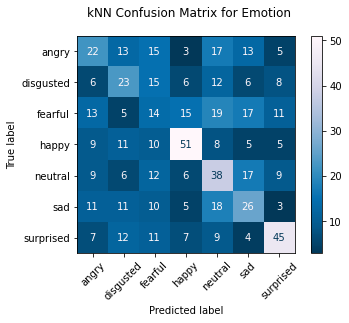

In [32]:
# Create confusion matrix
fig = plot_confusion_matrix(k_model, x_test_arr, y_test_arr, display_labels=k_model.classes_,cmap=cm.PuBu_r)
fig.figure_.suptitle("kNN Confusion Matrix for Emotion")
plt.xticks(rotation = 45)
plt.show()

#### What does the confusion matrix tell us?
It indicates that most of the numbers in the diagonal are larger than any of the numbers in their respective cross section, except the fearful class. This shows that there were more correct classifications than any individual misclassification, which does show that the model did learn  to differentiate between the different emotions to some extent.

In [33]:
# Refine hyperparameters 
param_grid = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': [1, 3, 5],
    'p': [1, 2],
    'leaf_size': [10, 20, 30],
}

grid_k = GridSearchCV(k_model, param_grid, n_jobs= -1, cv=5)
grid_k.fit(x_train_arr, y_labels_arr)

print(grid_k.best_params_) 

{'leaf_size': 10, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}


In [34]:
# Create refined model
k2_model = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', p = 2, leaf_size = 10, metric = 'minkowski')

# training model using train images
k2_model.fit(x_train_arr,y_labels_arr)

# refined model prediction
knn2_precited = k2_model.predict(x_test_arr)

# print accuracy score
print( 'The mean accuracy score is' + ' ' + str(accuracy_score(y_test_arr,knn2_precited)))

The mean accuracy score is 0.35545023696682465


#### Is the accuracy score good?
No. However, it has significantly improved from the previous model after using more optimal hyperparameters. This indicates that there are less misclassifications and a greater proportion of correct classifications. 

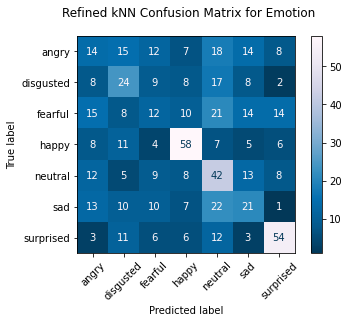

In [35]:
# Create refined model confusion matrix 
fig = plot_confusion_matrix(k2_model, x_test_arr, y_test_arr, display_labels=k2_model.classes_,cmap=cm.PuBu_r)
fig.figure_.suptitle("Refined kNN Confusion Matrix for Emotion")
plt.xticks(rotation = 45)
plt.show()

#### What does the confusion matrix tell us?
Similar to the previous confusion matrix, the numbers in the diagonal are greater than any of the numbers in their respective cross section, but now except angry and fearful. However, compared to the previous model there are a greater number of correctly classified data (i.e., the sum of numbers in the diagonal in this matrix is overall greater than the sum of numbers in the diagonal from the previous matrix). This indicates that with the fine-tuned hyperparameters, the model was able to more accurately classify emotion. 

### MLP: Multilayer Perceptron – Supervised Learning Neural Network

A multilayer perceptron is an artificial neural network that contains input, output, and hidden layers of neurons. Each neuron takes in inputs and combines them in a weighted sum and if this sum exceeds some threshold, the neuron fires and produces an output. The threshold is determined by some arbitrary activation function The mapping between inputs and outputs are non-linear in MLP and feedforward as the output from one layer becomes the input of the subsequent layer. 

In [36]:
# Create model
m_model = MLPClassifier(hidden_layer_sizes = [28,28], activation = 'relu', solver = 'adam', max_iter = 200)

# training model using train images
m_model.fit(x_train_arr, y_labels_arr)

# model prediction
MLP_predicted = m_model.predict(x_test_arr)

# print accuracy score 
print( 'The mean accuracy score is' + ' ' + str(accuracy_score(y_test_arr,MLP_predicted)))

The mean accuracy score is 0.3175355450236967


#### Is the accuracy good?
No. The accuracy is also suboptimal when utilizing MLP as there are more misclassifications than there are correctly classified data. There is great room for improvement, and thus we must fine-tune the hyperparameters.

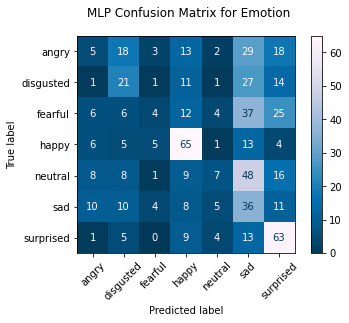

In [37]:
# Create confusion matrix 
fig = plot_confusion_matrix(m_model, x_test_arr, y_test_arr, display_labels=m_model.classes_,cmap=cm.PuBu_r)
fig.figure_.suptitle("MLP Confusion Matrix for Emotion")
plt.xticks(rotation = 45)
plt.show()

#### What does the confusion matrix tell us?
There are some classes of emotion that are better classified than others. Specifically, happy and surprised had much greater correct classifications than the other emotion classes. This is indicated by the large diagonal numbers that correspond to these classes, and hence MLP may be better suited for certain emotions that are more easily distinguishable from the rest. 

In [38]:
# fine-tune our hyperparameters 
param_grid = {
    'hidden_layer_sizes': [(28,28), (50,50), (100,100)],
    'max_iter': [100, 200, 300],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(m_model, param_grid, n_jobs= -1, cv=5)
grid.fit(x_train_arr, y_labels_arr)

print(grid.best_params_) 

{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}


In [39]:
# Create our refined model
m2_model = MLPClassifier(hidden_layer_sizes = [100,100], activation = 'tanh', solver = 'adam', max_iter = 300,alpha = 0.05,learning_rate='constant')

# training model using train images
m2_model.fit(x_train_arr, y_labels_arr)

# refined model prediction
MLP2_predicted = m2_model.predict(x_test_arr)

# print accuracy score 
print( 'The mean accuracy score is' + ' ' + str(accuracy_score(y_test_arr,MLP2_predicted)))

The mean accuracy score is 0.34913112164297


#### Is the accuracy score good?
No. Again, compared to the previous model the accuracy increased significantly once utilizing the fine-tuned hyperparameters. The number indicates that there a greater number of misclassifications than there are correct classifications.

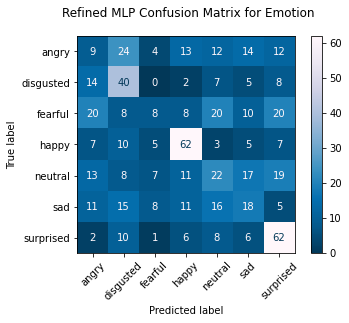

In [41]:
# Create refined model confusion matrix 
fig = plot_confusion_matrix(m2_model, x_test_arr, y_test_arr, display_labels=m2_model.classes_,cmap=cm.PuBu_r)
fig.figure_.suptitle("Refined MLP Confusion Matrix for Emotion")
plt.xticks(rotation = 45)
plt.show()

#### What does the confusion matrix tell us?
Similar to the previous, there are some classes of emotion that are better classified than others, this time was disgusted, happy, and surprised. However, there was a great increase in correctly classified data for the disgusted and neutral classes which helped increase the accuracy of the model. 

## Conclusion

That's all for the emotion classification algorithm! With a big of preprocessing, feature extraction, and model training we were able to classify images based on emotion! Future directions would be to improve computational time during the ESRGAN preprocessing phase and also to improve the accuracy of the models by training them with larger datasets while fine-tuning the hyperparameters. Another interesting direction would be to classify non-facial images based on emotion as landscapes can elicit the same strong feelings. 

## References
1. https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/
2. https://arxiv.org/abs/1809.00219
3. https://www.tensorflow.org/hub/tutorials/image_enhancing
4. https://imotions.com/blog/facial-action-coding-system/
5. https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761#:~:text=Summary-,The%20k%2Dnearest%20neighbors%20(KNN)%20algorithm%20is%20a%20simple,that%20data%20in%20use%20grows.
6. https://towardsdatascience.com/multilayer-perceptron-explained-with-a-real-life-example-and-python-code-sentiment-analysis-cb408ee93141
7. https://michael-fuchs-python.netlify.app/2021/02/03/nn-multi-layer-perceptron-classifier-mlpclassifier/
8. https://neuro.psychiatryonline.org/doi/10.1176/appi.neuropsych.14070169#:~:text=The%20prevalence%20of%20alexithymia%20in%20the%20general%20population%20is%20approximately%2010%25.&text=Alexithymia%20seems%20to%20be%20normally,it%20being%20a%20personality%20dimension.
9. https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
10. https://nobaproject.com/modules/functions-of-emotions#:~:text=Because%20emotions%20have%20this%20communicative,behavior%20(Keltner%2C%202003).
11. https://google.github.io/mediapipe/solutions/face_mesh.html
12. https://downloads.hindawi.com/journals/cin/2022/8032673.pdf
13. https://github.com/google/mediapipe/issues/2031